#Nearest neighbors strategy#


'Nearest neighbors' is probably the best known machine learning algorithm. It is based on the similarity principle, basically something like 'if it walks like a duck and quacks like a duck, it is most probably a duck'.
The basis of NN algorithm is search for data points that are most similar to a new, previously unknown point. When similar points are found, a statistical approcach can be used to calculate probable outcomes, on which a trading decicion can be based.

In this notebook we'll design a volatility trading strategy that uses two indicators.

In [1]:
# take a look at nearest neighbors of VXX
%pylab inline
import tradingWithPython as twp
import tradingWithPython.lib.yahooFinance as yf
import tradingWithPython.lib.cboe as cboe
from sklearn import neighbors
import pandas as pd


figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


##Strategy thesis##

Suppose that next-day returns of VXX can be predicted with two parameters:
* the steepness of the VIX futures contango or backwardation
* short term return of the VXX

Now we'll create an independant variables dataset $X$, that contains a measure of the futures contango/backwardation (variable $a$) and a running sum of VXX returns (variable $b$).
 $$a=VIX-VXV $$
 $$b=\sum_{i=n-k}^nr_i$$

Where $r$ is the daily return of *VXX*

Of course, the variables in the dataset can be anything (any indicator that you can imagine) and we can have as many of them as we like. Two-dimensional space however does not suffer from the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and is easy to visualise. It is preferable to keep the amount of dimensions to a minimum, but adding extra inputs could increase classifying performance.

The strategy is based on the assumption that
$$r_{i+1} = F(X)+\epsilon $$

Where $F(X)$ is some (unknown) transfer function and $\epsilon$ is noise.
We will use knn algorithm to estimate $F(X)$ and use this estimation for predicting outomes of $r_{i+1}$ for new values of *a* and *b*

##Prepare data##
As usual, we need to prepare the data first.

In [2]:
# get closing prices
vxx = yf.getHistoricData('VXX')['adj_close']
vol = cboe.getHistoricData()

Got 1668 days of data


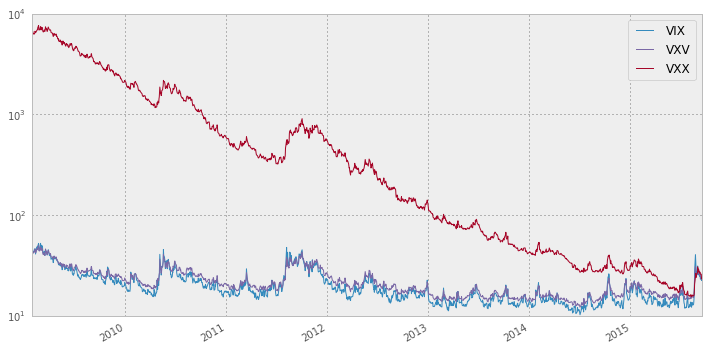

In [11]:
# combine data into one DataFrame
data = pd.DataFrame({'VIX':vol.VIX,'VXV':vol.VXV,'VXX':vxx}).dropna()
data.plot(logy=True)

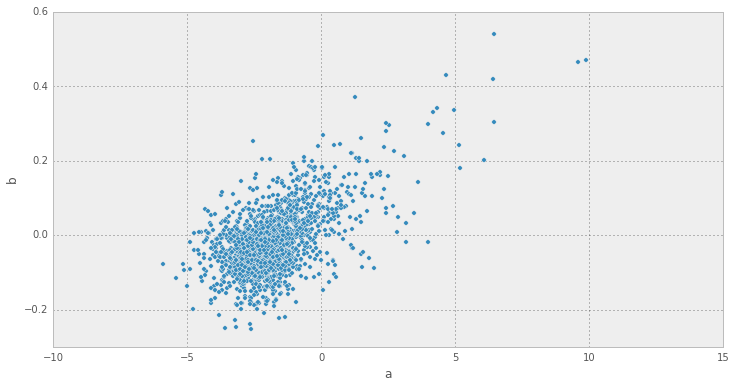

In [4]:
# now we will create dataset X containing independant variables and dataset Y with next-day returns of VXX

k = 5 # lookback for rolling sum of the VXX returns
R = data.VXX.pct_change() # daily returns of VXX

X = pd.DataFrame({'a':data.VIX-data.VXV,'b':pd.rolling_sum(R,k)}) # independent variables dataset,with columns 'a' and 'b'
Y= R.shift(-1) # next-day return

# X and Y at this moment contain some rows with nan values. 
# These will cause problems later on as knn does not handle these well.
# it is a good idea to clean up the missing values, this can be done on one line.
uniqueIdx = pd.concat((X,Y), axis=1).dropna().index # concatenate X and Y to a joint dataset, drop nans and get index

# reindex X and Y to rows that don't contain nans (removes some rows)
X = X.reindex(uniqueIdx)
Y = Y.reindex(uniqueIdx)

X.plot(kind='scatter',x='a',y='b') # plot the data

Notice that in the chart above the scales on the axis are not equal. Whie *a* has ranges from -5 to 10, *b* only varies in -0.2 .. 0.3 range. This will affect the nearest neighbors search algorithm, as points on the *a* axis will have a preference because of its tighter range and thus shorter distances.
It is a good practice to scale the variables so their ranges are similar. 

Another thing to keep in mind is correlation between independant variables. If *a* would show a clear relationship to *b*, it would be advisable to create a linear combination of the two and use it as a single variable. This will reduce number of dimensions, which is usually useful when amount of data points is low (and with financial data that is almost always the case).

In our case there does not seem to be much correlation between *a* and *b*, but we will need to scale

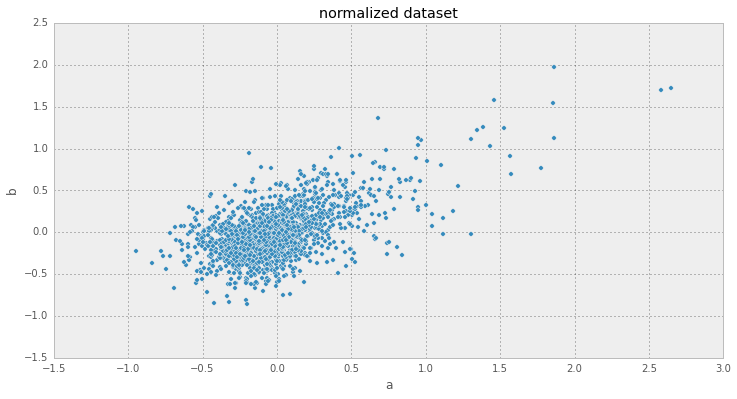

In [5]:
# for normalization we'll create a small class Normalizer:

class Normalizer(object):
    """ normalizes data to zero mean and 5-95 percentiles range"""
    def __init__(self,data):
        # determine mean and range of data based on input dataset #
        self.mean = data.mean(0) # data mean
        self.rng = data.quantile(0.95)-data.quantile(0.05) # data range. Quantiles take care of outliers
        
    def transform(self,data):
        # normalize input data #
        """ normalize dataset """
        return (data-self.mean)/self.rng
        
normalizer = Normalizer(X) # create normalizer

Xn =normalizer.transform(X) # Xn will now be the normalized dataset
Xn.plot(kind='scatter',x='a',y='b') # plot the data
title('normalized dataset')

In this dataset, we can now find points closest to some point $x=(a,b)$ . We will use the NearestNeighbors class from the [scikit-learn](http://scikit-learn.org/stable/) library for this.

Transformed x:
a    0.852311
b    0.402470
dtype: float64


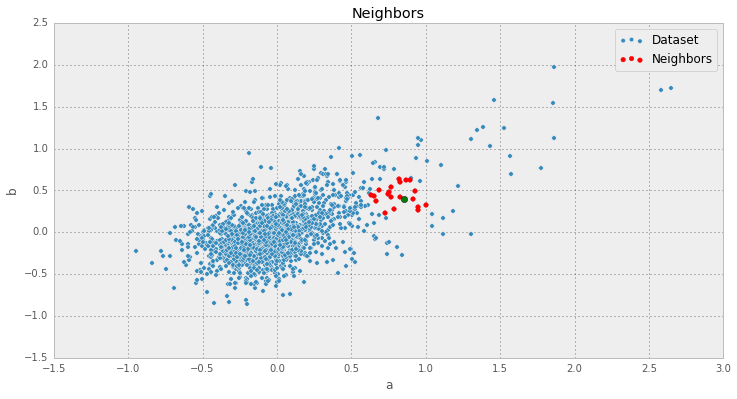

In [6]:
knn = neighbors.NearestNeighbors(20) # create class, default number of neighbors returned will be 30
knn.fit(Xn) # train with dataset X

x = [2,0.1] # this will be the point for which the neighbors are found. NOT normalized
xn = normalizer.transform(x) # transform point to the normalized coordinates
print 'Transformed x:\n', xn
dist, idx = knn.kneighbors(xn) # get distances and indices of neighbors
idx = idx[0] # get a vector containing row indices of nearest neghbors

# just a convenience for using column names
a,b = 'a','b'

# plot on 2d
ax = Xn.plot(kind='scatter', x=a, y=b, label= 'Dataset')
plot(xn[0],xn[1],'go')
Xn.ix[idx].plot(kind='scatter', x=a, y=b, color='red', ax=ax, label='Neighbors')
title('Neighbors')


Once the neighbouring points are found, statistics can be calculated on them. This is a basis for building a NN based strategy

Average return: -0.46 % , Sharpe: -1.23 


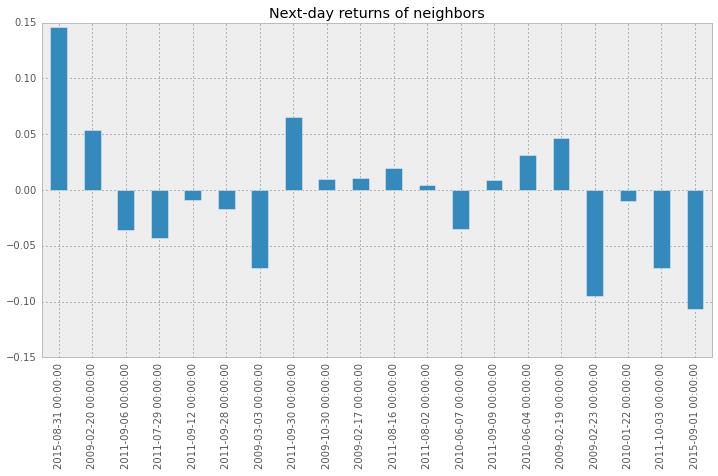

In [7]:
avgRet = Y[idx].mean()
sharpe = sqrt(250)*avgRet/Y[idx].std()

print 'Average return: %.2f %% , Sharpe: %.2f ' % (avgRet*100, sharpe)

figure()
Y[idx].plot(kind='bar')
title('Next-day returns of neighbors')

##Create trader class##

This class will hold the training dataset and provide 'trading advice' for a new input
The trading adive will be positive when the sharpe of neigboring points is higher than provided threshold value. Short position will be advised when sharpe is lower than the threshold.

In [8]:
class NNTrader(object):
    """ nearest neighbor trading class"""
    
    def __init__(self, X,Y, n=20):
        """ Init class
        X: independent variables
        Y: dependent variable
        n: number of neighbors to use
        """
        self.normalizer = Normalizer(X) # create normalizer class
        
        
        # copy data, normalize X
        self.X = self.normalizer.transform(X) # internal X dataset is normalized. 
        self.Y = Y.copy() # Y is just a copy 
        
        self.knn = neighbors.NearestNeighbors(n) # create nn class, default number of neighbors returned will be 30
        self.knn.fit(self.X) # train with dataset X
        
    def findNeighbors(self,x):
        """find neighbors for point x. Returns neighboring points from Y"""
        
        xn = normalizer.transform(x) # transform point to the normalized coordinates
        
        dist, idx = self.knn.kneighbors(xn) # get distances and indices of neighbors
        idx = idx[0] # get a vector containing row indices of nearest neghbors

        return self.Y[idx]
    
    def advice(self,x, thresh=0):
        """ get 
        x: input variable
        thresh: sharpe threshold to go long or short
        returns: trading advice, short:-1, no action: 0, long: 1
        """
        
        Y = self.findNeighbors(x)
        avgRet = Y.mean()
        sharpe = sqrt(250)*avgRet/Y.std()
        
        
        if sharpe > thresh:
            return 1
        elif sharpe <-thresh:
            return -1
        else:
            return 0
        


Simulating with 5 neighbors
Simulating with 10 neighbors
Simulating with 20 neighbors
Simulating with 30 neighbors
Simulating with 50 neighbors
Simulating with 80 neighbors


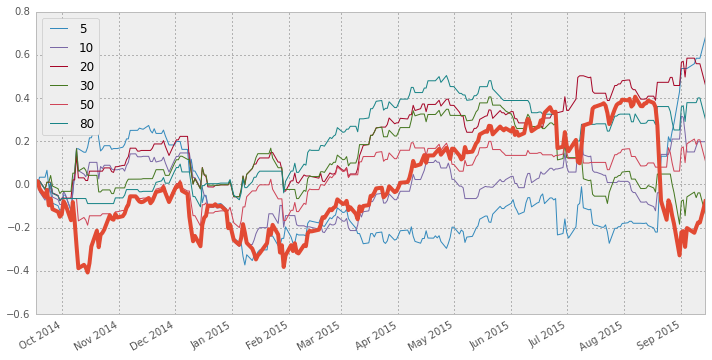

In [9]:
# simulate strategy for different numbers of neighbors

split = 250 # out-of-sample period
N = [5,10,20,30,50,80]
PNL = pd.DataFrame(index=X.index, columns=N) # pnl for all runs
thresh = 2

for n in N: # execute multiple runs
    print 'Simulating with %i neighbors' % n

    trader = NNTrader(X.ix[:-split,:], Y.ix[:-split], n=n) # create trader class

    pnl = pd.Series(index = Y.index) # pnl for a single run
    
    # simulate for each day, only out-of-sample
    for idx in X.index[-split:]:
        x = X.ix[idx,:]
        tradeDir = trader.advice(x, thresh=thresh)
        pnl[idx] = Y[idx]*tradeDir

    PNL[n] = pnl
        
PNL[-split:].cumsum().plot()
(-Y[-split:]).cumsum().plot(ax=gca(),linewidth=4)

In [10]:
# calculate Sharpe ratios for different strategies and buy-and-hold
print twp.sharpe(PNL.ix[-split:,:])
print twp.sharpe(-Y[-split:])

5     1.081975
10    0.360626
20    0.933800
30   -0.259833
50    0.234465
80    0.664160
dtype: float64
-0.111600476252


##Conclusion##
The strategy does not have a stellar performance, however it seems to outperform the buy-and-hold approach. One notable thing is that the strategy seems to avoid sharp volatility move in August 2015.

Strategy performance will vary depending on the training period, number of neighoring points, statistics used for trade decision and input parameters. It is still a challenge to find a combination that performs well, but the NN technique can be easily applied to any input-output combination and works well with multi-dimensional input spaces.